In [13]:
import pandas as pd
from fastai.vision import *
from fastai.metrics import AUROC
%matplotlib inline

# Data locations
path = "data/"

In [14]:
df = pd.read_csv(path + "train.csv")
df.head()

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1


In [15]:
data = ImageDataBunch.from_csv(
    path, folder="train/", csv_labels="train.csv", valid_pct=0.3, ds_tfms=get_transforms()
).normalize(imagenet_stats)

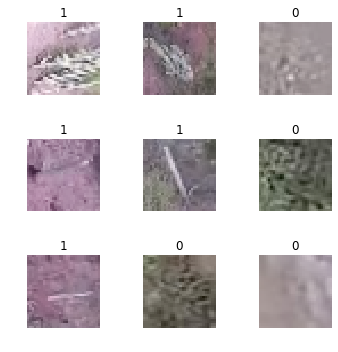

In [16]:
data.show_batch(rows=3, figsize=(5,5))

In [17]:
# Copied from fastai to test/debug
def auc_roc_score(input:Tensor, targ:Tensor):
    "Using trapezoid method to calculate the area under roc curve"
    fpr, tpr = roc_curve(input, targ)
    d = fpr[1:] - fpr[:-1]
    sl1, sl2 = [slice(None)], [slice(None)]
    sl1[-1], sl2[-1] = slice(1, None), slice(None, -1)
    return (d * (tpr[tuple(sl1)] + tpr[tuple(sl2)]) / 2.).sum(-1)

def roc_curve(input:Tensor, targ:Tensor):
    "Returns the false positive and true positive rates"
    targ = (targ == 1)
    desc_score_indices = torch.flip(input.argsort(-1), [-1])
    input = input[desc_score_indices]
    targ = targ[desc_score_indices]
    d = input[1:] - input[:-1]
    distinct_value_indices = torch.nonzero(d).transpose(0,1)[0]
    threshold_idxs = torch.cat((distinct_value_indices, LongTensor([len(targ) - 1]).to(targ.device)))
    tps = torch.cumsum(targ * 1, dim=-1)[threshold_idxs]
    try:
        fps = (1 + threshold_idxs - tps)
    except:
        import pdb
        pdb.set_trace()
    if tps[0] != 0 or fps[0] != 0:
        fps = torch.cat((LongTensor([0]), fps))
        tps = torch.cat((LongTensor([0]), tps))
    fpr, tpr = fps.float() / fps[-1], tps.float() / tps[-1]
    return fpr, tpr

In [21]:
# Using AUROC() works, but auc_roc_curve directly not??
learn = cnn_learner(data, models.resnet50, metrics=AUROC())

In [22]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (downsample): Sequential(
          (0): Conv2d(64, 256, kernel_s

In [23]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,auroc,time
0,0.188449,0.128294,0.987310,00:17


In [20]:
learn.save("stage-1")

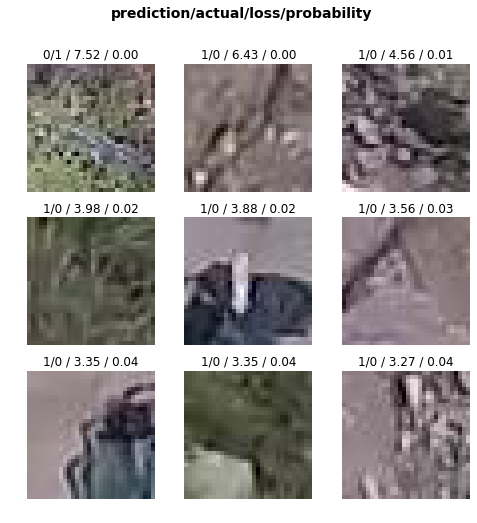

In [23]:
interp = ClassificationInterpretation.from_learner(learn)
losses, idxs = interp.top_losses()
interp.plot_top_losses(9, figsize=(8, 8))

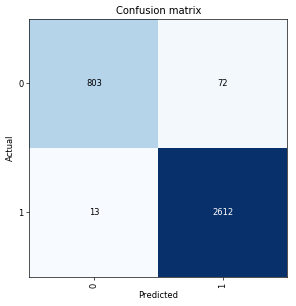

In [27]:
interp.plot_confusion_matrix(figsize=(5, 5), dpi=60)

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.057361,0.022006,0.006571,00:17


In [31]:
learn.load("stage-1");

In [32]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


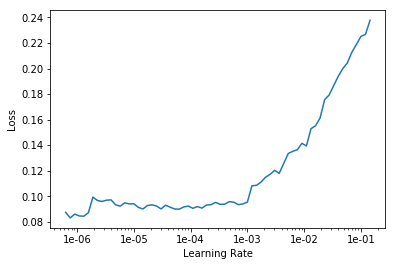

In [33]:
learn.recorder.plot()

In [34]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=slice(1e-6, 1e-3))

epoch,train_loss,valid_loss,error_rate,time
0,0.075495,0.047298,0.016857,00:17
1,0.063691,0.028438,0.010857,00:17
2,0.044034,0.028003,0.011143,00:17
